# LEO PAGGEN i6236337

# NLP 2024
# Lab 2: Word Embeddings

Throughout the course we have discussed different ways to represent a word. The latest one (and the most successful in terms of results) is using word embeddings: we represent each word as a vector consisting of numbers. The vector encodes the meaning of the word. These numbers (or weights) for each word are learned using various machine learning models. In this lab, we explore how to create such vectors given a corpus (note that in the real world, you can also load the trained word vectors, and you will almost never have to train them from scratch), which properties they have and what kind of tasks we can solve with them.

By the end of this lab you should be able to:
- Implement and/or use built-in functions to preprocess your data (once again)
- Execute `word2vec` based on a corpus
- Inspect and test word embeddings properties
- Use word embeddings to get sentence representations (aka sentence embeddings)
- Use sentence embeddings to solve more complicated tasks like information retrieval
- Design evaluation frameworks for specific NLP tasks and assess their difficulty

### Score breakdown

Exercise | Points
--- | ---
[Exercise 1](#e1) | 3
[Exercise 2](#e2) | 3
[Exercise 3](#e3) | 3
[Exercise 4](#e4) | 5
[Exercise 5](#e5) | 10
[Exercise 6](#e6) | 6
[Exercise 7](#e7) | 5
[Exercise 8](#e8) | 5
[Exercise 9](#e9) | 5
[Exercise 10](#e10) | 5
[Exercise 11](#e11) | 5
[Exercise 12](#e12) | 15
Total | 70

This score will be scaled down to 1 and that will be your final lab score.

### Instructions for delivery (Deadline: 17/May late night, wildcards possible)

+ Make sure that you include a proper amount/mix of comments, results and code.
+ In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.
+ You are asked to deliver only your executed notebook file, .ipnyb and nothing else. Enjoy!
+ Honor code applies to these tasks. Only individual work should be submitted.
+ While you may talk with others about this lab, we ask that you write your solutions individually. If you do discuss specific tasks with others please include their names below.
+ It is mandatory to list and disclose any website (or other resource) you used (e.g. stackoverflow) as well as any genAI tools (e.g. chatGPT) used.

Collaborators: list collaborators here

**I talked with Jerry about...**

Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow): list websites where you found code (or other info) as well as include information on how you used genAI tools (e.g. prompts):

I asked chatGPT about...

## 0. Setup

As in the last lab, we will be using huggingface datasets library ([https://huggingface.co/datasets](https://huggingface.co/datasets)). You can find the detailed documentation and tutorials here: [https://huggingface.co/docs/datasets/en/index](https://huggingface.co/docs/datasets/en/index)

If you don't have it installed you can run the code below:

In [712]:
! pip install -U datasets~=2.18.0

As usual, we start by importing some essential Python libraries and we will be using. Apart from `gensim` (which is going to be used for word2vec), we have already seen the others.

In [713]:
!python -m pip install -U gensim

In [714]:
import re  # for regular expressions
import random
import math

import numpy as np
import matplotlib.pyplot as plt
import datasets
import gensim
import nltk
import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lpaggen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Load and Preprocess Data

*Sentence compression* involves rephrasing sentences to make them shorter while still retaining the original meaning. A reliable compression system would be valuable for mobile devices and could also serve as a component in an extractive summarization system.

The dataset we are going to use can be found on [Huggingface](https://huggingface.co/datasets/embedding-data/sentence-compression). It concerns a set of 180,000 pairs of sentences, aka it is a parallel corpus of sentences and their equivalent compressions. It has been collected by harvesting news articles from the Internet where the headline appears to be similar to the first sentence and that property is used to find an "extractive" compression of the sentence.

For example, for the sentence

`"Regulators Friday shut down a small Florida bank, bringing to 119 the number of US bank failures this year amid mounting loan defaults"`

the compressed equivalent (based on the dataset) is:

`"Regulators shut down small Florida bank"`.


For more information you can read the original paper (from Google) [here](https://aclanthology.org/D13-1155.pdf). We strongly recommend going over the paper to gain further insights. Notice that the paper is from 2013, therefore word embeddings have not been widely introduced yet in NLP tasks, meaning that the methods applied were based on the traditional NLP pipeline (feature extraction + ML).

### 1.1 Loading the Dataset

The dataset will be loaded as a Pandas DataFrame. This may take a few minutes because of the large size of the data.

Make sure to inspect the dataset and make sure it is imported properly.

In [715]:
ds = datasets.load_dataset('embedding-data/sentence-compression')
print(ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 180000
    })
})


In [716]:
for i in range(10):
    print(ds['train'][i])

{'set': ["The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints.", 'USHL completes expansion draft']}
{'set': ['Major League Baseball Commissioner Bud Selig will be speaking at St. Norbert College next month.', 'Bud Selig to speak at St. Norbert College']}
{'set': ["It's fresh cherry time in Michigan and the best time to enjoy this delicious and nutritious fruit.", "It's cherry time"]}
{'set': ['An Evesham man is facing charges in Pennsylvania after he allegedly dragged his girlfriend from the side of his pickup truck on the campus of Kutztown University in the early morning hours of Dec. 5, police said.', 'Evesham man faces charges for Pa.']}
{'set': ["NRT LLC, one of the nation's largest residential real estate brokerage companies, announced several executive appointments within its Coldwell Banker Residential B

The dataset comes with only the `train` split so we will have to split it ourselves.

In [717]:
split_ds = ds['train'].train_test_split(test_size=0.2)
print(split_ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['set'],
        num_rows: 36000
    })
})


### 1.2 Preprocessing the dataset
In this section we will prepare the dataset, aka clean the sentences and tokenizem.

First, let's write the function to clean the text. It can be similar to the one from the previous lab (Lab1) but make sure that it makes sense for this dataset and task.

More specifically, think about lower-casing, punctuation, stop-words and lemmatization/stemming and the impact it might have on the dataset. Also reflect on the fact that with word2vec we want to uncover semantic relationships between words, whereas with bag-of-words we were trying to capture different morphological variations.

<a name='e1'></a>
### Exercise 1 (points 3)
Fill in the following function ot clean the dataset.

In [718]:
def clean(text):
    """
    Cleans the given text
    Args:
        text: a str with the text to clean

    Returns: a str with the cleaned text

    """

    # Empty text
    if type(text) not in (str, np.str_) or text == '':
        print('empty text', type(text), type(text) not in (str, np.str_), text)
        return ''

    # 'text' from the example can be of type numpy.str_, let's convert it to a python str
    text = str(text)

    # Clean the text
    text = re.sub("\'s", " ", text)  # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)

    #you might need more
    #add them here

    ### YOUR CODE HERE
    
    text = re.sub("…", " . ", text)
    text = re.sub(r'\.\.\.(?=\s|$)', ' .', text)
    text = re.sub(" \" ", " ", text)
    text = re.sub(r'(?<=\w)-|-(?=\w)', '  ', text)
    text = re.sub(r'#\w+', 'HASHTAG', text)
    text = re.sub(r'@\w+', 'PERSON', text)
    text = re.sub(r'(?<=\w)\\', '', text)
    text = re.sub(r'(?=\w)\"|\"(?=\w)', '', text)
    text = re.sub(r'(?=\w)\'', '', text)
    text = re.sub(r'(?<=\w)-(?=\w)', '  ', text)
    text = re.sub(r'\~(?=\w)', '', text)
    text = re.sub(r'\.', ' .', text)
    text = re.sub(r',', ' , ', text)
    text = re.sub(" dont ", " do not ", text)
    text = re.sub(r'\?+', ' ?', text)
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'(?=\w)\:', ' : ', text)
    text = re.sub(r'\~\w+', '', text)
    text = re.sub(r'(?=\w)\?|\?(?=\w)', ' ? ', text)
    text = re.sub(r'(?=\w)!|!(?=\w)', ' ! ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'(?<=\w)\.', '. ', text)
    text = re.sub(r'\((?<=\w)|(?<=\w)\)', '', text)
    text = re.sub(" & ", " and ", text)
    text = re.sub(r'\d+', 'NUMBER', text) # chat gpt -> regex to replace numbers by "NUMBER" token
    text = re.sub(r'[\$£€¥₹₽₩₺₫₴₦]', 'CURRENCY', text) # chatGPT -> replace currency symbols by "CURRENCY" token
    text = re.sub(r'``', '', text)
    text = re.sub(r'`', '', text)
    text = re.sub(r'\'', '', text)
    text = re.sub(r'\"', '', text)
    text = re.sub(r'[\'"]', '', text)
    text = re.sub(r'\b(?:[A-Za-z]\.){2,}', 'ABBREVATION', text) # chatGPT -> replace all abbreviations by "ABBREVIATION" token
    text = re.sub(r'\b[A-Z][a-z]+\b', 'NAME', text) # chatGPT -> replace all words starting with capital letter with "NAME" token
    
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'t", " not ", text)
    text = re.sub("\'re", " are ", text)
    
    text = text.lower()


    ### YOUR CODE ENDS HERE

    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

    text = text.strip()

    # Update the example with the cleaned text
    return text

The following function will apply the function (sic) you just wrote to the whole dataset. More specifically, it takes the first entry (`sentence`) from the set of uncompressed/compressed pairs, applies the `clean` function and saves the processed sentence in the field `clean_sentence`. The same is dome for the compressed version of the sentence (saved as `clean_compressed`).

In [808]:
def clean_dataset(example):
    """
    Cleans the sentence and compressed sentence in the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: updated example with 'clean_sentence' and 'clean_compressed' cleaned

    """
    sentence, compressed = example['set']
    clean_sentence = clean(sentence)
    clean_compressed = clean(compressed)
    example['clean_sentence'] = clean_sentence
    example['clean_compressed'] = clean_compressed
    return example

Below we apply the function to the whole dataset (using `map`) and we can also inspect the result.

In [809]:
split_ds = split_ds.map(clean_dataset)
print(split_ds)

Map: 100%|██████████| 36000/36000 [00:04<00:00, 7466.68 examples/s]

DatasetDict({
    train: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed', 'sentence_tokens'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['set', 'clean_sentence', 'clean_compressed', 'sentence_tokens'],
        num_rows: 36000
    })
})


Let's examine some examples from the dataset and make sure that we got the results we wanted. At this step, it might be necessary to revisit some pre-processing steps if you are not happy with the results.

In [810]:
for i in range(10):
    print(split_ds['train'][i])

{'set': ['Several Jordanian banks operating in the Palestinian territories are planning to raise their capital to $50 million to meet the Palestinian Monetary AuthorityPalestinian Monetary Authority recently issued requirements.', 'Jordanian banks in Palestinian territories planning to raise capital to $50 million'], 'clean_sentence': 'name name banks operating in the name territories are planning to raise their capital to currencynumber million to meet the name name authoritypalestinian name name recently issued requirements .', 'clean_compressed': 'name banks in name territories planning to raise capital to currencynumber million', 'sentence_tokens': ['name', 'name', 'banks', 'operating', 'in', 'the', 'name', 'territories', 'are', 'planning', 'to', 'raise', 'their', 'capital', 'to', 'currencynumber', 'million', 'to', 'meet', 'the', 'name', 'name', 'authoritypalestinian', 'name', 'name', 'recently', 'issued', 'requirements', '.']}
{'set': ['On February 1, Iran foreign minister receive

<a name='e2'></a>
### Exercise 2 (points 3)

As always, we will need to tokenize the dataset in order to train our own `word2Vec` model in the next section. We will use the [Natural Language Toolkit (NLTK) library]([https://www.nltk.org/]) (https://www.nltk.org/).

Complete the following function to split the text into tokens using the `word_tokenize()` function. Check the [documentation](https://www.nltk.org/api/nltk.tokenize.word_tokenize.html?highlight=word_tokenize) first.

Note that there are different tokenizers e.g. `RegexpTokenizer` where you can enter your own regexp, `WhitespaceTokenizer` (similar to Python's string.split()) and `BlanklineTokenizer`.

In [811]:
# if you want you can remove the stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    """
    Tokenizes the `text` parameter using nltk library
    Args:
        text: a string representing a sentence to be tokenized

    Returns: a list of tokens (strings)

    """

    ### YOUR CODE HERE

    tokens = nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)

    ### YOUR CODE ENDS HERE
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lpaggen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next, the function will be applied to the whole dataset (as we did with the pre-processing) and `sentence_tokens` field will be created to store the result.

In [812]:
def tokenize_dataset(example):
    """
    Tokenizes 'clean_sentence' columns in the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: updated example with 'sentence_tokens' columns

    """
    cleaned_sentence = example['clean_sentence']
    tokens = tokenize(cleaned_sentence)
    example['sentence_tokens'] = tokens
    return example

In [813]:
split_ds = split_ds.map(tokenize_dataset)

Map: 100%|██████████| 36000/36000 [00:03<00:00, 9340.13 examples/s] 


In [814]:
# this helps to see if anything needs to change in the cleaning of the text above
for i in range(10):
    print(split_ds['train']['sentence_tokens'][i])

['name', 'name', 'banks', 'operating', 'in', 'the', 'name', 'territories', 'are', 'planning', 'to', 'raise', 'their', 'capital', 'to', 'currencynumber', 'million', 'to', 'meet', 'the', 'name', 'name', 'authoritypalestinian', 'name', 'name', 'recently', 'issued', 'requirements', '.']
['name', 'name', 'number', ',', 'name', 'foreign', 'minister', 'received', 'name', 'ambassador', 'in', 'name', 'name', 'name', 'on', 'the', 'occasion', 'of', 'completion', 'of', 'his', 'diplomatic', 'activity', ',', 'apa', 'reports', 'quoting', 'isna', 'news', 'agency', '.']


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106574f10>>
Traceback (most recent call last):
  File "/Users/lpaggen/miniforge3/envs/nlp/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


['number', 'de', 'febrero', 'de', 'number', ',', 'number', ':', 'numberwarsaw', ',', 'name', 'number', 'name', 'number', 'name', 'name', 'winning', 'poet', 'name', 'name', 'died', 'at', 'number', 'years', 'old', 'in', 'her', 'house', 'in', 'the', 'southern', 'city', 'of', 'name', ',', 'announced', 'her', 'representative', 'name', 'name', '.']
['name', 'name', 'name', 'name', 'sent', 'out', 'an', 'alert', 'to', 'parents', 'recently', 'to', 'inform', 'them', 'that', 'student', 'has', 'been', 'diagnosed', 'with', 'a', 'bacterial', 'infection', 'that', 'can', 'be', 'easily', 'spread', 'through', 'nose', 'and', 'mouth', 'secretions', '.']
['name', 'search', 'is', 'a', 'false', 'messiah', ',', 'claimed', 'name', 'name', 'at', 'this', 'week', 'name', 'name', 'name', 'in', 'name', 'name', '.']
['name', 'and', 'storm', 'recovery', 'payouts', 'in', 'name', 'from', 'the', 'name', 'name', 'name', 'name', 'and', 'state', 'total', 'more', 'than', 'currencynumber', '.number', 'million', 'since', 'nam

Since we will need the tokenized sentences, we can use the following statement to extract them from the `train` split of our dataset.

In [815]:
tokenized_sentences = split_ds['train']['sentence_tokens']
print(len(tokenized_sentences))
print(tokenized_sentences[:10])

144000
[['name', 'name', 'banks', 'operating', 'in', 'the', 'name', 'territories', 'are', 'planning', 'to', 'raise', 'their', 'capital', 'to', 'currencynumber', 'million', 'to', 'meet', 'the', 'name', 'name', 'authoritypalestinian', 'name', 'name', 'recently', 'issued', 'requirements', '.'], ['name', 'name', 'number', ',', 'name', 'foreign', 'minister', 'received', 'name', 'ambassador', 'in', 'name', 'name', 'name', 'on', 'the', 'occasion', 'of', 'completion', 'of', 'his', 'diplomatic', 'activity', ',', 'apa', 'reports', 'quoting', 'isna', 'news', 'agency', '.'], ['number', 'de', 'febrero', 'de', 'number', ',', 'number', ':', 'numberwarsaw', ',', 'name', 'number', 'name', 'number', 'name', 'name', 'winning', 'poet', 'name', 'name', 'died', 'at', 'number', 'years', 'old', 'in', 'her', 'house', 'in', 'the', 'southern', 'city', 'of', 'name', ',', 'announced', 'her', 'representative', 'name', 'name', '.'], ['name', 'name', 'name', 'name', 'sent', 'out', 'an', 'alert', 'to', 'parents', 'rec

Notice the difference in the types of the different structures we use. Run the following cell to check the types. Do they make sense to you?

In [816]:
#type of original dataset
print(type(split_ds))
print("--")
#type of original sentence
print(split_ds['train'][1])
print(type(split_ds['train'][1]))
print("--")
#type of pre-proceesed sentence
print(split_ds['train']['clean_sentence'][1])
print(type(split_ds['train']['clean_sentence'][1]))
print("--")
#type of tokenized sentence
print(split_ds['train']['sentence_tokens'][1])
print(type(split_ds['train']['sentence_tokens'][1]))
print("--")

<class 'datasets.dataset_dict.DatasetDict'>
--
{'set': ['On February 1, Iran foreign minister received Turkish ambassador in Tehran Salim Karaoglu on the occasion of completion of his diplomatic activity, APA reports quoting ISNA news agency.', 'Iran foreign minister received Turkish ambassador'], 'clean_sentence': 'name name number , name foreign minister received name ambassador in name name name on the occasion of completion of his diplomatic activity , apa reports quoting isna news agency .', 'clean_compressed': 'name foreign minister received name ambassador', 'sentence_tokens': ['name', 'name', 'number', ',', 'name', 'foreign', 'minister', 'received', 'name', 'ambassador', 'in', 'name', 'name', 'name', 'on', 'the', 'occasion', 'of', 'completion', 'of', 'his', 'diplomatic', 'activity', ',', 'apa', 'reports', 'quoting', 'isna', 'news', 'agency', '.']}
<class 'dict'>
--
name name number , name foreign minister received name ambassador in name name name on the occasion of completion 

yes, all makes sense, the dictionary just holds the 3 different sentence, token, clean compressed forms,

the str is the string of the sentence

the list is meant for the individual tokens

## 2. Word2Vec word embeddings

Before proceeding below make sure that you understand the way Word2Vec words. Refer to the lecture slides and/or the textbooks. Here we provide a (very) rough introduction that is lacking many details we discussed in class.

Word2vec operates on the principle that words appearing in similar contexts tend to have similar meanings. There are two main algoriths with diffferent variations. in Skip-gram the model precits the context words given the target word, whereas in CBOW the model predicts the target word given its context words (words surrounding it). During training (which can take a lot of time in case of big corpora), word2Vec updates the vector representations of words to maximize the probability of correctly predicting the target or context words. If we use a neural network, training is done with gradient descent.

We need to decide on different parameters that will influence the behavior and performance of word2Vec models. These include the dimensionality of the word vectors which determines the size of the vector space in which words are embedded, and the window (context) size, which defines the number of context words considered in each training instance. Additionally, the choice of training algorithm (CBOW or Skip-gram), learning rate, number of training epochs need to be tuned.

Nough said, it's time to train our own Word2Vec embeddings. We will use the powerful [Gensim library](https://radimrehurek.com/gensim/models/word2vec.html). Make sure to read the documentation to decrypt the parameters we need to tune (embedding vector size, context window, type of algorithm etc.). The training might take some time, depending on the parameters you use.



In [728]:
import os
print(os.cpu_count())

10


In [774]:
from gensim.models import Word2Vec

# i changed to CBOW, embedding size 150, changed window size by a bit. # switched back to skip-gram
# i have 10 CPU cores, so i changed workers = 10
embedding_size = 100
w2v_model = Word2Vec(tokenized_sentences, vector_size=embedding_size, min_count=5, window=5, sg=0, hs=0, seed=1,
                     workers=10) # CBOW instead of skip-gram, maybe works better? sg=0
w2v_model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=20)

(46058188, 78891460)

In [730]:
#w2v_model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=15)

The Word2Vec model has `wv` attribute. We can use it to retrieve the whole vocabulary (aka for how many words we learned embeddings for).

In [731]:
vocab = list(w2v_model.wv.key_to_index)
print(len(vocab))

17260


Here you can see the word cloud created from the vocabulary.

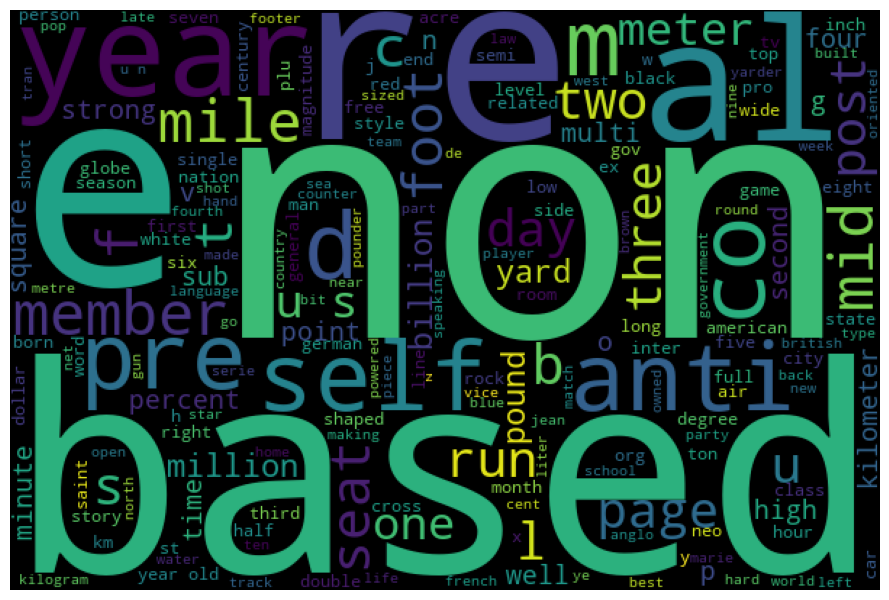

In [818]:
# visualizing our vocab with a word cloud.
from wordcloud import WordCloud

# Generate a word cloud image for words
combined_vocab = ' '.join(vocab)
wordcloud = WordCloud(width=600, height=400).generate(combined_vocab)
plt.figure(figsize=(9, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

Let's explore a bit further the embeddings. In the following cells, the embedding of a single word is returned. Double-check the dimensions (as sanity check). This is like inspecting the `W` matrix (weights) that we discussed in the lecture.

In [824]:
# vector of a particular model. note that it is 100 dimensional as specified.

In [823]:
# can also do like this.
w2v_model.wv['apple']

array([ 0.3687209 , -0.16469865,  0.12301101,  0.0118596 ,  0.1087783 ,
       -0.39687845,  0.02359077, -0.3310816 , -0.12215706, -0.20335056,
       -0.0307478 , -0.37063497, -0.27294436, -0.20140105,  0.17749302,
       -0.12597531,  0.16484386, -0.76019096, -0.11724918, -0.09268752,
        0.08358899,  0.6763067 ,  0.2276899 , -0.35265896, -0.1657253 ,
        0.18397546, -0.53987795, -0.0062545 ,  0.10203669, -0.41294295,
       -0.26799732, -0.1370199 ,  0.3845689 , -0.03621864,  0.2529987 ,
       -0.14809866,  0.5524045 ,  0.4242766 ,  0.35012832,  0.09753147,
       -0.40331638, -0.2867303 , -0.4250587 , -0.05331782,  0.19186571,
        0.11742609, -0.15042984, -0.38983783, -0.19242299, -0.33084252,
       -0.09417555,  0.39298636,  0.21153171,  0.27900824, -0.37450114,
       -0.03158199,  0.8204956 ,  0.00673819,  0.2107142 , -0.02544713,
        0.2290537 ,  0.23708096,  0.11902888, -0.5977846 , -0.47115168,
       -0.40877977,  0.29644945,  0.22310302,  0.32048786, -0.05

`word2vec` offers different functions to easily run very common tasks. For example, there are different functions to find the most similar words.

Check the documentation on how [`most_similar`](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html) and [`similar_by_word`](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.similar_by_word.html) can be used.

In [735]:
# most similar words to a given word
print(w2v_model.wv.most_similar('what', topn=10))

# also u can use
print(w2v_model.wv.similar_by_word('miss', topn=5))

[('something', 0.50532466173172), ('whatever', 0.4911404550075531), ('whether', 0.4892929494380951), ('why', 0.4650338590145111), ('how', 0.4576423764228821), ('nothing', 0.44996771216392517), ('everything', 0.44604170322418213), ('thing', 0.4034721255302429), ('so', 0.38052433729171753), ('really', 0.37245285511016846)]
[('skip', 0.577915370464325), ('rejoin', 0.5521731376647949), ('undergo', 0.516438364982605), ('join', 0.508976936340332), ('play', 0.49410247802734375)]


In [736]:
print(w2v_model.wv.most_similar('why', topn=10))

[('whether', 0.5893875360488892), ('how', 0.5828012824058533), ('really', 0.5124791860580444), ('something', 0.47536784410476685), ('what', 0.46503379940986633), ('actually', 0.46161091327667236), ('afraid', 0.42814621329307556), ('yes', 0.4204157590866089), ('truth', 0.4203914701938629), ('exactly', 0.41599491238594055)]


In [737]:
print(w2v_model.wv.similar_by_word('who', topn=5))

[('whose', 0.5251567363739014), ('whom', 0.38427793979644775), ('british', 0.35994789004325867), ('female', 0.3577386438846588), ('where', 0.35489949584007263)]


<a name='e3'></a>
### Exercise 3 (points 3)

While there is already a similarity metric in the `word2Vec` class, we will write our own implementation of the cosine similarity. Complete the following funciton that given any two vectors will compute the cosine similarity. If you don't remember the formula for the cosine similarity, revisit the course material. Notice that the function receives numpy arrays and recall that you can express cosine similarity as a dot product. Use numpy functions to write an efficient implementation.

In [738]:
def cosine_similarity(vector1, vector2):
    """
    Computes the cosine similarity between two vectors
    Args:
        vector1: numpy array of the first vector
        vector2: numpy array of the second vector

    Returns: cosine similarity

    """
    ### YOUR CODE HERE

    cosine_sim = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

    return cosine_sim

    ### YOUR CODE ENDS HERE

In [739]:
cosine_similarity(np.array([0, 1, 2]), np.array([0, 1, 2]))

0.9999999999999998

We can now compare our implementation with the one in the Word2Vec model and confirm what we already expected.

In [775]:
# simalarity between two words
word1 = 'alive'
word2 = 'biology'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.04892175
0.048921738


In [741]:
# simalarity between two words. similar words
word1 = 'alive'
word2 = 'life'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.14766254
0.14766252


In [742]:
# simalarity between two words. dissimilar words
word1 = 'alive'
word2 = 'dead'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.31276727
0.31276724


In [743]:
# simalarity between two words. unrelated words
word1 = 'alive'
word2 = 'horse'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

0.22226559
0.22226559


In [744]:
# simalarity between two SAME words
w2v_model.wv.similarity('equal', 'equal')
word1 = 'equal'
word2 = 'equal'
print(w2v_model.wv.similarity(word1, word2))
print(cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2]))

1.0
1.0


The next function contains the code to plot a similarity matrix between multiple words (e.g. if we want to compare 10 words and their pair-wise similarities). It requires a matrix with similarities (as input) and labels (aka the words) to display in the final figure.

In [745]:
def plot_similarity_matrix(matrix, labels):
    """
    Displays a plot of the `matrix` of size (N x N) with the labels specified as a list of size N
    Args:
        matrix: a square-sized (N x N) numpy array
        labels: a list of strings of hte size N
    """

    fig, ax = plt.subplots()
    im = ax.imshow(matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}',
                           ha="center", va="center", color="w")

    # ax.set_title("Give a title if you want")
    fig.tight_layout()
    plt.show()

<a name='e4'></a>
### Exercise 4 (points 5)

In the following, we will explore some properties of word embeddings through some examples. We will use 6 example words for this purpose but feel free to explore some of your own (also for Exercise 5).

First, fill in the next cell to create a similarity matrix between a list of words. Then, call the function given above that plots the similarity matrix, along with the word labels.

In the cell, below comment on the results. Based on the word2vec parameters you explored, do they make sense?

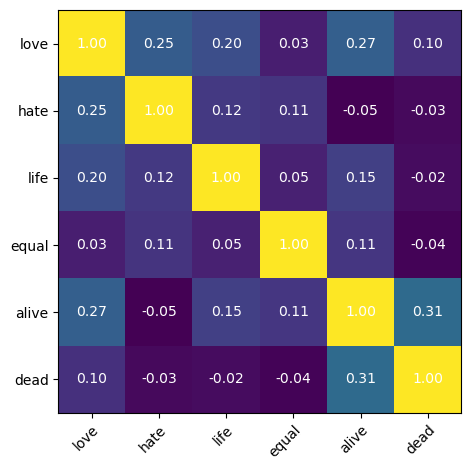

In [746]:
list_of_words = ['love', 'hate', 'life', 'equal', 'alive', 'dead']

similarity_matrix = np.zeros((len(list_of_words), len(list_of_words)), dtype=float)

### YOUR CODE HERE

for ix, i in enumerate(list_of_words):
    for ixx, j in enumerate(list_of_words):
        similarity_matrix[ix][ixx] = cosine_similarity(w2v_model.wv[i], w2v_model.wv[j])

### YOUR CODE ENDS HERE


plot_similarity_matrix(similarity_matrix, list_of_words)

<a name='e5'></a>
### Exercise 5 (points 10)

For this exercise, experiment with different words and their similarities plotted. Also, take into account the different parameters of word2vec and more specifically the window size (context) and the role it plays in the types of embeddings we can learn.

What happens if I pick a small context window?
What happens if I pick a large context window?

Are there noticeable patterns? Are they expected? Try to find examples that word embeddings make sense (based on your hypothesis) and not.

Comment on your findings below.

min_count = 10
window = 1
using = CBOW
workers = 10


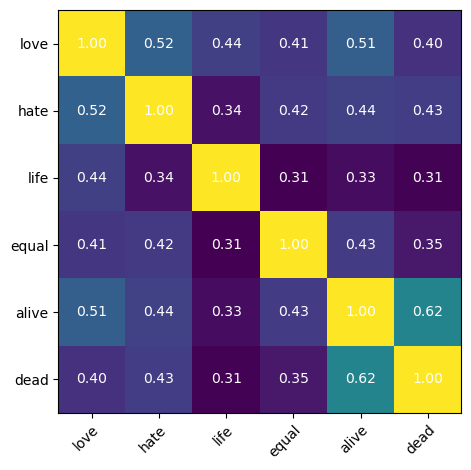

min_count = 10
window = 2
using = CBOW
workers = 10


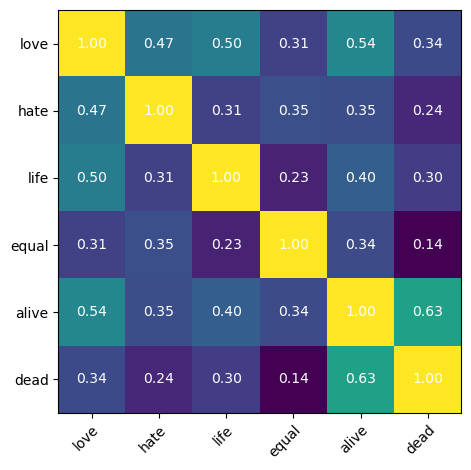

min_count = 10
window = 3
using = CBOW
workers = 10


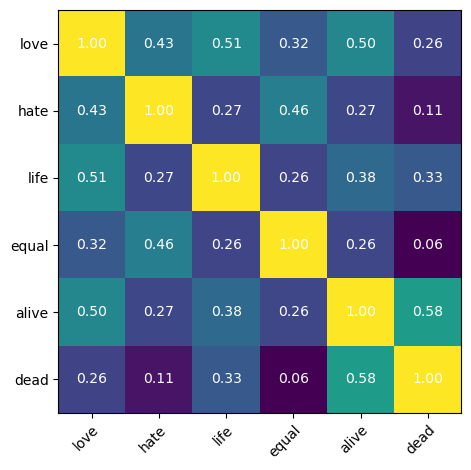

min_count = 10
window = 4
using = CBOW
workers = 10


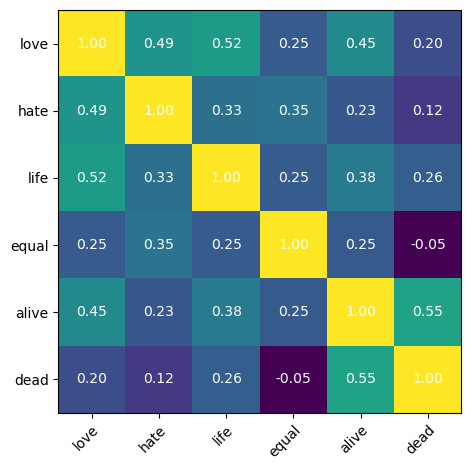

min_count = 10
window = 5
using = CBOW
workers = 10


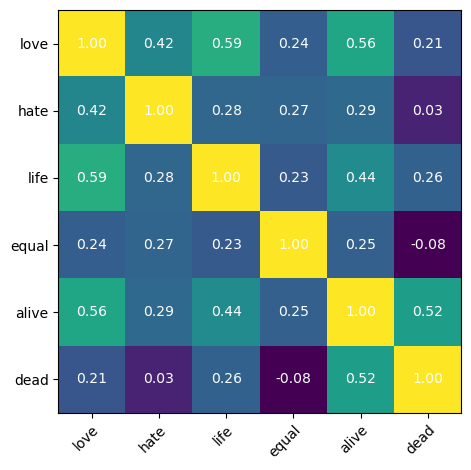

min_count = 10
window = 6
using = CBOW
workers = 10


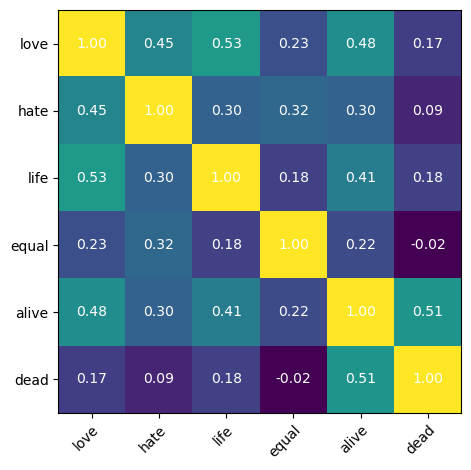

In [747]:
#### YOUR CODE HERE
for window_size in range(1, 7): # run from size 1 to 6
    w2v_1 = Word2Vec(tokenized_sentences, vector_size=embedding_size, min_count=10, window=window_size, sg=0, hs=0, seed=1, workers=10)

    list_of_words = ['love', 'hate', 'life', 'equal', 'alive', 'dead']

    similarity_matrix = np.zeros((len(list_of_words), len(list_of_words)), dtype=float)

    for ix, word1 in enumerate(list_of_words):
       for ixx, word2 in enumerate(list_of_words):
            similarity_matrix[ix][ixx] = cosine_similarity(w2v_1.wv[word1], w2v_1.wv[word2])

    print(f"min_count = 10\nwindow = {window_size}\nusing = CBOW\nworkers = 10")
    plot_similarity_matrix(similarity_matrix, list_of_words)

### YOUR CODE ENDS HERE

# comments

##SKIP-GRAM##

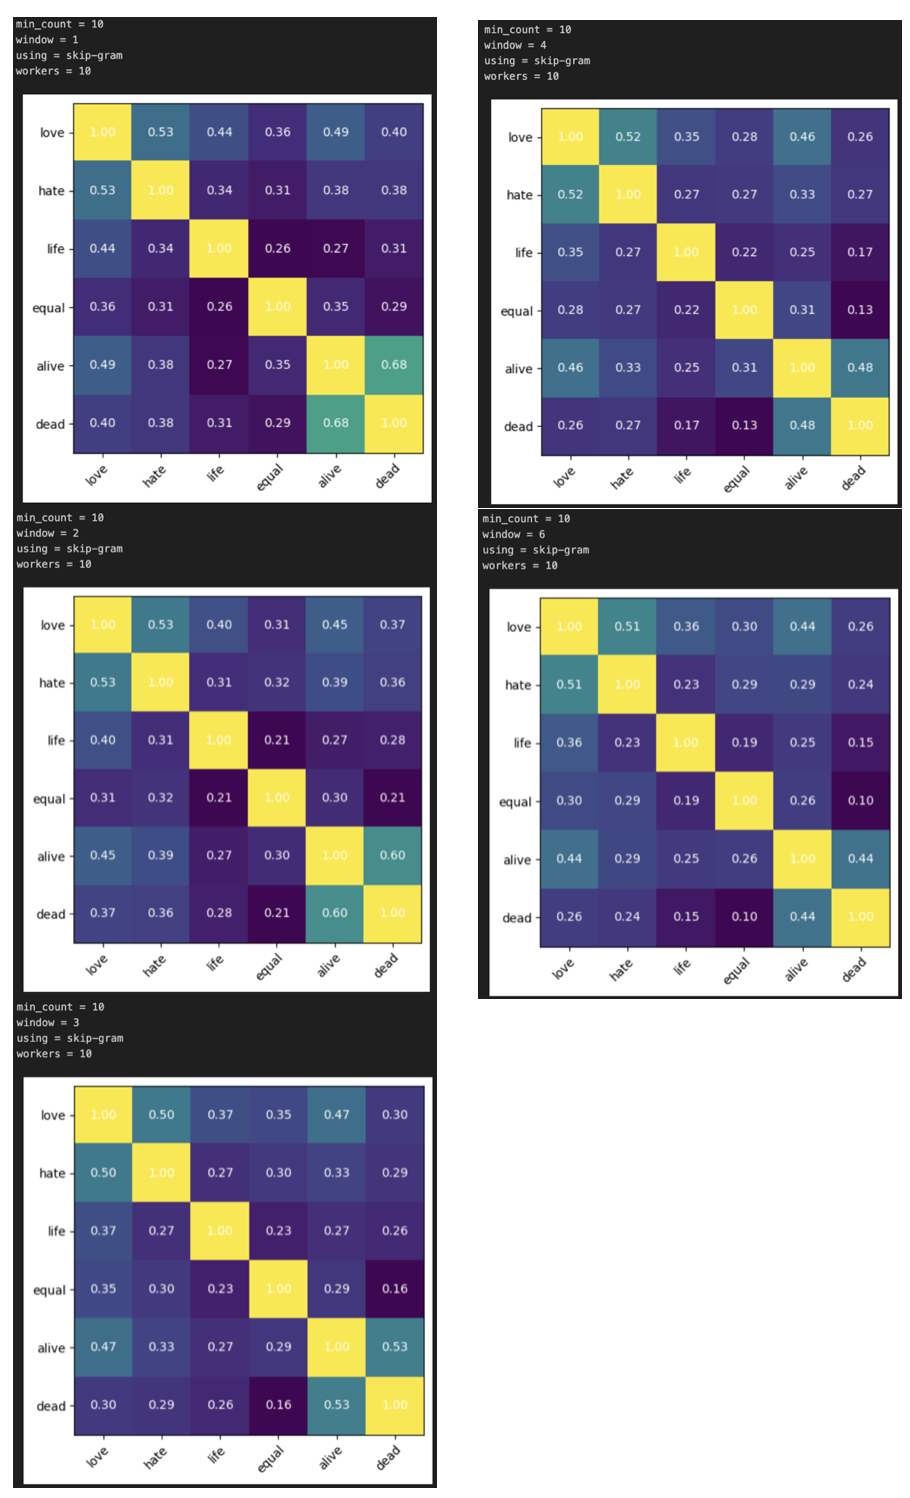

##CBOW##

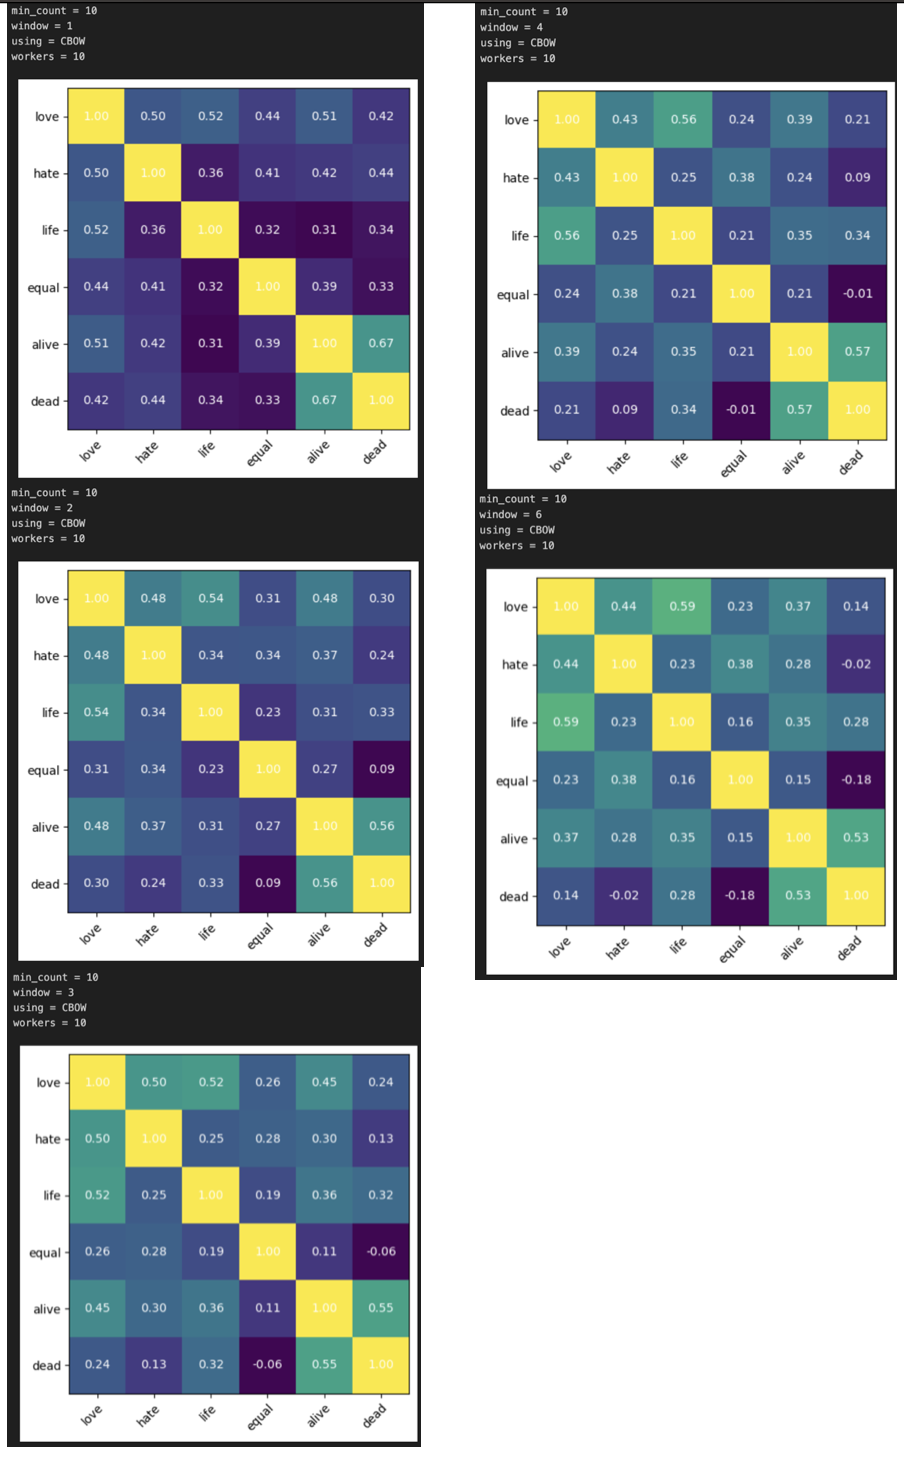


- comments

both models seem to classify similar words in a similar way, the only thing that is really a noticeable change after running all this is maybe the effect of the window size parameters. "love" and "hate" also don't seem to be classified exactly as they should be, which i would expect to be negative, but here they have a somewhat posiitve association, which is interesting. 

Also, picking a larger context window seems to make the models compute a lower and lower cosine similarity for most words as we increase the window size. For example, this is visible for the CBOW and the words "dead" and "love" 

This is expected, because as window size increases, we 1. allow other words to influence the computations, and 2. this makes it so that maybe other further words appear more frequently in the window, which reduces some cosine similarities for the words. 

## 3. Pre-trained embeddings

In this short section you will load the pre-trained embeddings of your choice. Gensim library maintains a storage containing some pre-trained models. You can read more about it [here](https://github.com/piskvorky/gensim-data) ([https://github.com/piskvorky/gensim-data](https://github.com/piskvorky/gensim-data)). Be sure to read the README of this repository.

Let's first load the info of what models are available.

In [748]:
import json
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
print(json.dumps(info['models'], indent=2))

{
  "fasttext-wiki-news-subwords-300": {
    "num_records": 999999,
    "file_size": 1005007116,
    "base_dataset": "Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py",
    "license": "https://creativecommons.org/licenses/by-sa/3.0/",
    "parameters": {
      "dimension": 300
    },
    "description": "1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).",
    "read_more": [
      "https://fasttext.cc/docs/en/english-vectors.html",
      "https://arxiv.org/abs/1712.09405",
      "https://arxiv.org/abs/1607.01759"
    ],
    "checksum": "de2bb3a20c46ce65c9c131e1ad9a77af",
    "file_name": "fasttext-wiki-news-subwords-300.gz",
    "parts": 1
  },
  "conceptnet-numberbatch-17-06-300": {
    "num_records": 1917247,
    "file_size": 1225497562,
    "base_dataset": "ConceptN

<a name='e6'></a>
### Exercise 6 (points 6)

Load the pre-trained word embeddings model of your choice (like we did in the lecture: e.g. try different pre-trained corpora and different types of embeddings (like GloVe or FastText)). You can use the gensim implementation and functionality to download and load several types of embeddings, but you are not limited to it.

Next, perform the analysis of the similarities between words as you did in Exercise 5. Compare your trained word2vec with the pretrained model you downloaded. Try to explain the numerical differences based on what you know on how these models were trained.

Note: Pre-trained embeddings might be difficult to load and use (memory requirements) so you might have to work locally there. You don't need to submit (really, don't!) the pre-trained word embeddings you used but make sure to include a link in your delivered notebook.

In [805]:
model = api.load('glove-wiki-gigaword-300')

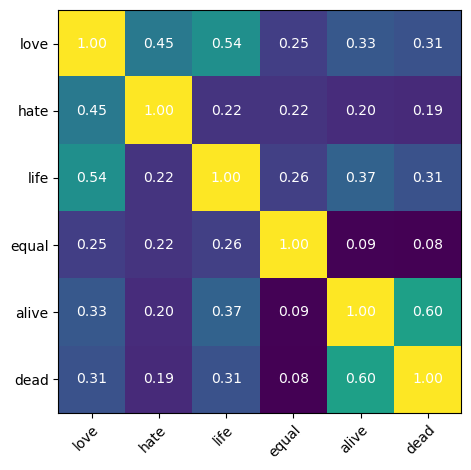

In [807]:
### YOUR CODE HERE

list_of_words = ['love', 'hate', 'life', 'equal', 'alive', 'dead']

similarity_matrix = np.zeros((len(list_of_words), len(list_of_words)), dtype=float)

for ix, i in enumerate(list_of_words):
    for ixx, j in enumerate(list_of_words):
        similarity_matrix[ix][ixx] = cosine_similarity(model[i], model[j])

plot_similarity_matrix(similarity_matrix, list_of_words)

### YOUR CODE ENDS HERE

// your comments

# comments

Differences in the models performance arise due to a couple of factors: 
- the pre-trained model is trained on a far greater vocabulary than the word2vec is
- the pre-trained model has also benefited from countless of hours of fine-tuning 
- glove uses global word co-occurrence stats, and word2vec uses CBOW or skip-gram. 
- also depends what the glove dataset looked like, if there was nothing similar to our train set, we can see why that might be a problem

Below is the matrix for the Glove model (pre-trained). Most of the cosine similarities seem to make sense, except maybe that  it tends to underestimate the real-life similarity of some words, such as "alive" and "life". Also some interesting results with "equal" and "hate", i'd expect that to be closer to 0.
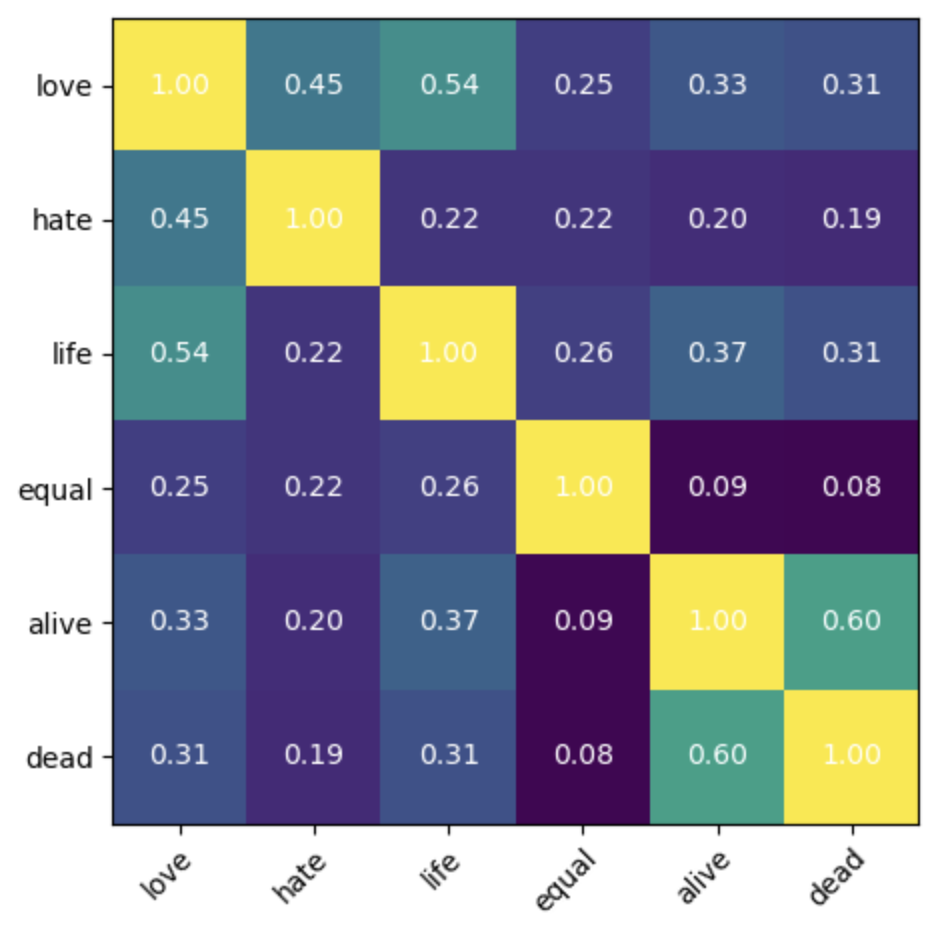

Below is the matrix for the word2vec model we trained previously

What we can notice immediately, is that the computed cosine similarity of both models is quite different. For some words, such as "alive" and "dead", we actually get pretty close results, but for some other words like "equal" and "dead", the word2vec cosine similarities do not seem to have any real world meaning. The Glove model, on the other hand, recognizes those words have almost no relation. Experimenting with different window sizes for the word2vec model has some effects on the results too, but this is discussed in 5

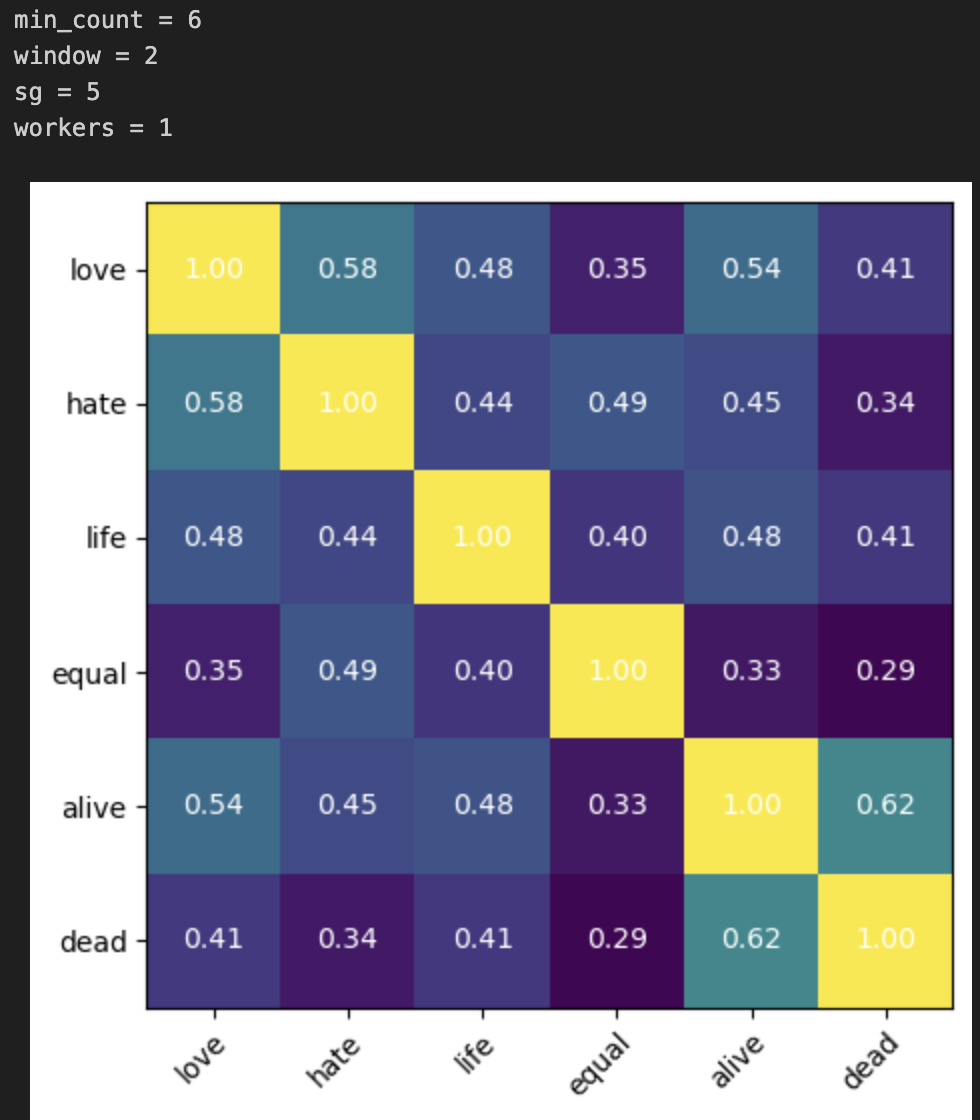

If you encounter problems with not enough RAM you can modify and run the following cell to unload the pretrained model from memory. Ofcourse, change the variable name to whatever you used.

In [751]:
# del model

## 4. Sentence Embeddings by Averaging Word2Vec Embeddings

Word embeddings are a powerful model for representing words and their meaning (in terms of distributional similarity). As we discussed in class, we can use them in a wide variety of tasks with more complex architectures. Word vectors offer a dense vector for each word. What if we wanted to represent a sentence (or a document) based on word vectors. How can we do that?

In the course, we will see different architectures that take into account the sequence of words (by combining their vectors). A first naive but simple and sometimes (as we are going to see) quite effective approach would be to represent a sentence with an embedding vector that is the average of the word vectors that form the sentence.

So formally, this is what we are aiming for:

$
\text{Sentence_Embedding} = \frac{1}{N} \sum_{i=1}^{N} \text{Word_Embedding}_i
$

where:
* $N$ is the number of words in a sentence
* $\text{Word_Embedding}_i$ is the word vector for the $i$-th in the sentence.

Things to note:
* The embedding vector for the sentence will obviously have the same dimension as the word embedding.
* This representation ignores the word order (like bag-of-words). During the course we will see how we can overcome this limitation by using sequence models.

<a name='e7'></a>
### Exercise 7 (points 5)

Complete the function below that takes as input the sentence in the form of tokens (so it's a list of words) and calculates the sentence embedding vector. First, we would need to retrieve the word embeddings for each word from our trained Word2Vec model and then average the vectors.

Note: There can be cases where all tokens from a sentence are out-of-vocabulary words (OOV). Return None in that case. We will filter out the sentences where it occurs.

In [752]:
def embed_sentence_word2vec(tokens):
    """
    Calculates the sentence embedding by averaging the embeddings of the tokens
    Args:
        tokens: a list of words from the sentence

    Returns: a numpy array of the sentence embedding

    """
    #### YOUR CODE HERE
    #### CAUTION: be sure to cover the case where all tokens are out-of-vocabulary!!!
    #### Return None in that case - we will filter out those cases later.

    word_vec = []  # list to store word embeddings

    # get word embedding for the tokens
    for word in tokens:
        if word in w2v_model.wv:
            word_vec.append(w2v_model.wv[word])
    if len(word_vec) == 0: # if all words are OOV, return None
        return None

    # average the vectors
    return np.mean(word_vec, axis=0)

    ### YOUR CODE ENDS HERE

Now we can apply the function to the whole dataset. Here we do it both for the sentence and the compressed version. You should know it by now, but this operation might take some time. The next cells will apply your function to the whole dataset.

In [753]:
def embed_sentence_word2vec_dataset(example):
    """
    Embeds the sentence and the compressed sentence in the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: updated example with 'sentence_word2vec' and 'compressed_word2vec' columns

    """
    sentence_tokens = example['sentence_tokens']
    clean_compressed = example['clean_compressed']
    compressed_tokens = tokenize(clean_compressed)

    sentence_embedding = embed_sentence_word2vec(sentence_tokens)
    compressed_embedding = embed_sentence_word2vec(compressed_tokens)

    example['sentence_word2vec'] = sentence_embedding
    example['compressed_word2vec'] = compressed_embedding
    return example

Huggingface datasets can return the columns as different types. Our embeddings are numpy arrays and it is a lot faster to return them as their type. The next cell will cast our dataset to return columns as numpy arrays.

Here we will filter out the examples where sentences (or their compressed versions) are composed of only OOV words. Notice the changed size of the dataset after the operation is complete.

Here you can see that the new dataset returned a single numpy array containing all sentence embeddings in our dataset. This is a lot more efficient than returning a list of arrays (which is the default behaviour). Below we check the type and the dimensionality.

We will be using `text` subset from our dataset to not use too much RAM. But if your system has enough memory, try to use `train` subset here.

In [754]:
sent_word2vec = np_ds['train']['sentence_word2vec']
compr_word2vec = np_ds['train']['compressed_word2vec']
print(type(sent_word2vec))
print(sent_word2vec.shape)
print(type(compr_word2vec))
print(compr_word2vec.shape)

<class 'numpy.ndarray'>
(143988, 100)
<class 'numpy.ndarray'>
(143988, 100)


## 5. Retrieving Sentences
In this section we will try use the vector representations in our dataset to retrieve only the relevant ones based on some user query. You can think of it as a search retrieval task (based on what we discussed in the relevant lecture) where a user provides a query (that is the compressed sentence) and the system returns the sentences that are more similar to the query.

In the information retrieval lecture, we discussed how to solve this retrieval problem by using bag-of-words as a representation basis. Here, we will use word embeddings instead.

<a name='e8'></a>
### Exercise 8 (points 5)

First step to a retrieval task is to embed the query (aka find a representation). We will do it the same way as we did for the sentences in our dataset. Complete the following function to return the embedding of the provided text.

In [755]:
def embed_query_word2vec(query):
    """
    Embeds the provided query using trained Word2Vec model.
    The query is first cleaned and tokenized (with the `clean()` and `tokenize() functions.
    Args:
        query: a str with the query

    Returns: a numpy array with the embedded qury

    """

    #### YOUR CODE HERE

    clean_query = clean(query)
    tokenized_query = tokenize(clean_query)

    embedding = embed_sentence_word2vec(tokenized_query)
    
    return embedding

    ### YOUR CODE ENDS HERE

Next we try the condensed representatin based on a simple query. Feel free to try different queries with different words. What happens if we have OOV words in a query?

In [756]:
query = "Marcel does not know how to paint"
print(query)

query_word2vec = embed_query_word2vec(query)
print(query_word2vec.shape)
print(query_word2vec)

Marcel does not know how to paint
(250,)
[-4.90384847e-01  1.95291638e-01 -2.92087346e-01  6.82105482e-01
  1.01273954e-01 -1.07199156e+00  9.53257680e-02 -7.90784299e-01
 -2.91629374e-01  3.33422869e-01 -5.34074366e-01  3.51593286e-01
 -8.90509635e-02  7.16394365e-01  2.87441492e-01 -5.61649859e-01
  6.52182043e-01 -3.51771623e-01  7.82625139e-01  2.27046713e-01
 -1.57004029e-01 -3.10188264e-01 -3.62035334e-01 -1.13460946e+00
 -1.79176733e-01  7.57661283e-01 -1.95239097e-01  7.40548372e-02
 -5.66699684e-01  8.73230636e-01  3.45106453e-01  4.72317524e-02
 -4.51700449e-01  1.05144358e+00  5.03346801e-01  2.72898048e-01
 -6.86307609e-01  2.09286287e-01 -5.07820547e-01  9.79334772e-01
  8.65879118e-01  9.87174392e-01  1.03687596e+00  7.11052641e-02
 -2.14671165e-01 -9.90422517e-02 -1.60453275e-01 -9.68726695e-01
  2.91805983e-01 -2.93348819e-01  2.97442138e-01  8.06595266e-01
  1.89646512e-01 -1.15765941e+00 -2.27965757e-01 -3.11511666e-01
  7.93656826e-01  1.08099962e-02 -7.59412408e-01 

<a name='e9'></a>
### Exercise 9 (points 5)

The next step in our retrieval system, would be to calculate the proximity of a query to our retrieval corpus (in our case that is all the sentences).

Complete the following function to calculate the cosine similarity between a vector (first parameter `vector`, that will usually be the query vector) and all other vectors (second parameter `other_vectors`, that will be the sentence embeddings in our case). Note that the `other_vectors` parameter is a single numpy array of size `N x D`, where $N$ is the number of vectors and $D$ is the dimension of each vector.

For maximum efficiency (we will need it) do not use loops. Try to write the implementation with numpy functions. Hint: matrix multiplication can be seen as calculating the dot product between rows and columns of the multiplied matrices.

In [757]:
def cosine_similarity_1_to_n(vector, other_vectors):
    """
    Calculates the cosine similarity between a single vector and other vectors.
    Args:
        vector: a numpy array representing a vector of D dimensions
        other_vectors: a 2D numpy array representing other vectors (of the size NxD, where N is the number of vectors and D is their dimension)

    Returns: a 1D numpy array of size N containing the cosine similarity between the vector and all the other vectors

    """

    #### YOUR CODE HERE

    dot = np.dot(other_vectors, vector)
    norm_vector = np.linalg.norm(vector)
    other_norm = np.linalg.norm(other_vectors, axis = 1)
    cos_sim = dot / (norm_vector * other_norm)

    return cos_sim

    ### YOUR CODE ENDS HERE

We will use the function to calculate the similarity of all sentences in the dataset to our query.

In [765]:
sent_word2vec.shape

(143988, 100)

In [766]:
query_word2vec.shape

(250,)

In [825]:
query_similarity = cosine_similarity_1_to_n(query_word2vec, sent_word2vec)
print(query_similarity.shape)
print(query_similarity[:10])

ValueError: shapes (35998,100) and (250,) not aligned: 100 (dim 1) != 250 (dim 0)

The following cell will select the most similar sentence.

In [826]:
most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(split_ds['train'][most_similar]['set'][0])

1294
0.3843324258462261
Kuwaiti Stock Exchange announced on Thursday 17 companies were banned from trading due to failure of presenting financial statements as scheduled, incurring losses above 75 percent of the capital or failure to hold the general assembly on time.


The following function will return the indices of the top-k elements in the array.

In [762]:
def top_k_indices(array, k, sorted=True):
    """
    Returns top-k indices from the 1D array. If `sorted` is `True` the returned indices are sorted in the descending order
    Args:
        array: a 1D numpy array
        k: a number of top indices to return
        sorted: if True, the returned indices are sorted in descending order

    Returns: a 1D array containing top-k indices

    """
    top_k = np.argpartition(array, -k)[-k:]
    if sorted:
      selected = array[top_k]
      sorted_selected = (-selected).argsort()
      top_k = top_k[sorted_selected]
    return top_k

In [763]:
# need to fix the error

top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['train'][idx]['set'][0])
    print(f'similarity: {query_similarity[idx]}')

Kuwaiti Stock Exchange announced on Thursday 17 companies were banned from trading due to failure of presenting financial statements as scheduled, incurring losses above 75 percent of the capital or failure to hold the general assembly on time.
similarity: 0.3843324258462261
Three youths from north India, who tried to fly on a single air ticket, landed in the police net on Tuesday.
similarity: 0.34296918203194604
Tampa Bay Rays outfielder BJ Upton, recovering from left shoulder surgery, indicated Wednesday that he could miss the start of the season.
similarity: 0.34029248030291914
Wairarapa families are already feeling the pinch as the cost of food and other essentials skyrocket, according to the district's biggest union.
similarity: 0.33340528722245
Residential care facilities across the north are benefiting from a new rate structure for clients.
similarity: 0.3247464471184748
One in four pensioners in the eastern region is putting their health at risk by skipping meals in a desperate

<a name='e10'></a>
### Exercise 10 (points 5)

Experiment with different queries (taking into account the nature of the dataset and your insights from the analysis so far).

Does the search perform well? When does it fail? Discuss several examples that are we get an expected but also unexpected results (find at least 5 from each category). Try to provide reasons for the good/bad result in each case (e.g. is there some error in the data, is there some linguistic phenomenon that we don't capture, is something wrong with our modeling with average embeddings, ...)

In [764]:
queries = [
    "the cat ate all the food",
    "the police shot at the intruders, killing them",
    "The bank is by the river",
    "natural language processing is hard",
    'mathematics is fun'
]

# run all queries from list
for query in queries:
    query_word2vec = embed_query_word2vec(query)
    query_similarity = cosine_similarity_1_to_n(query_word2vec, sent_word2vec)
    top_indices = top_k_indices(query_similarity, k=5).tolist()

    print(f"Query: {query}")
    for idx in top_indices:
        print(split_ds['train'][idx]['set'][0])
        print(f'Similarity: {query_similarity[idx]}')
    
    print("\n")

ValueError: shapes (143988,100) and (250,) not aligned: 100 (dim 1) != 250 (dim 0)

# comments

## skip gram with window size 

- QUERY: the cat ate all the food

ALL the local beaches monitored for bathing water quality met the minimum standard, with three out of five passing the most stringent tests.
Similarity: 0.6293440119671749
-> here, it is quite interesting this similarity does not make much sense at all. No "food", no "cat", this is probably because "food" and "cat" are simply not in the vocabulary, otherwise there would be some sentences with "cat" in them. 

Once again, French consumers find the Gourmandine to be the tastiest potato in the category potatoes, vegetables and fruit.
Similarity: 0.6222363470769368
-> same as above, this does not make any sense at all. Out of vocabulary words in my query most likely.

Public health officials in the Miami Valley have issued the following food safety advisory for all consumers, restaurants, grocery stories and any food operations affected by the recent power outages.
Similarity: 0.6648249682004679
-> Here, more emphasis was placed on food, but not at all on "cat" and "food" combined. The sense of the query "the cat ate all the food" is not represented at all in the sentence the model retrieves. Here, it is talking about actual food prices and power outages, when I was just asking about cats and food.

- QUERY: The bank is by the river
This is the mantra lived by the owner of the website Every Girl is a Princess.
similarity: 0.5975206900012374
-> This sentence does not make sense either in terms of its resemblance with my query. The word "bank" or "river" is nowhere to be seen. It is not out of vocabulary issue, however, as there are other sentences where this works perfectly fine!. 

Latin American stocks were on the rise Monday in line with Wall Street, where investors were heartened by encouragement from the government on the state of the economy.
Similarity: 0.5915139478094091
-> here, the retrieved sentence clearly deals with bank as a financial instutution, but ignores "river" entirely. Note that this is the case for the top 5 of documents retrieved, "river" is accorded less importance than "bank" is.

- QUERY: "natural language processing is hard"
A former chairman of the Leech Lake Band of Ojibwe has been sentenced to two years of probation on corruption charges.
Similarity: 0.5669488053458586
-> not only this one, but a few other sentences, are relevant to crime and corruption, rather than NLP itself. After all, the sequence of words "natural language processing" is probably not understood as "NLP" by the model at all.

- QUERY: "mathematics is fun"
A Myrtle Beach woman was charged with stabbing another woman after they argued because the women are dating the same person, according to a police report.
Similarity: 0.6196856648350054
-> here, same case as above with the NLP query, this has nothing to do with either "fun" or "mathematics", weird, and probably words out of vocabulary.

- QUERY: "the police shot at the intruders, killing them"
Akamai Technologies was upgraded by investment analysts at Credit Agricole from an "outperform" rating to a "buy" rating in a note issued to investors on Thursday.
Similarity: 0.7977079838672281
-> this again has no relation whatsoever to the query i asked for. I know however, that this is an issue with the model itself, not the query. 


### NOW I CHANGED THE MODEL, CHANGED EMBEDDING SIZE TO 75, WSIZE TO 5
### WE FIND MUCH MORE DECENT MATCHES FOR SOME QUERIES

Ranchi, Oct 17 Three girls of a family died in a Jharkhand village and three of their relatives were taken to hospital in critical condition, police said Friday.
Similarity: 0.4643738690465085

The Maine Department of Corrections says a prison inmate found dead in his cell died of natural causes.
Similarity: 0.4560350059271939


A man visiting his detained wife at the correctional institution for women in Mandaluyong City landed himself in jail after authorities found high grade methamphetamine hydrochloride or shabu in his possession.
Similarity: 0.4504932464998561


Authorities say a man accused of killing an Auburn University student confessed to shooting her.
Similarity: 0.44800050332635444


A man killed his mother over a minor family dispute at Laxmipur VDC-8 in the district Thursday night.
Similarity: 0.4446440310371225

## CHANGING THE WINDOW SIZE
- Query: "the cat ate all the food"
The NASA probe "Voyager 1" is approaching the edge of our solar system, the so-called the ``heliopause''.
Similarity: 0.48079728082389644
-> we can see from this example, that a window size too high can make the model very bad, police query still works quite well however.

## 5. Evaluating Retrieval

In this last section we will try to evaluate how good our sentence retrieval system is. To keep the computational resources manageable, we will use the test set for that as its size is more manageable.

Recall from the lecture in IR that there are several metrics to evaluate retrieval performance by taking into account the relevance of the retrieved results to the query. We will use Recall@K here (for more metrics and more details refer to the lecture slides and the textbooks).

RRecall@K is a metric used to measure the effectiveness of a search system in retrieving relevant documents within the top $K$ retrieved documents. It calculates the proportion of relevant documents retrieved within the top-$K$ results, compared to the total number of relevant documents in the collection.

$
\text{Recall@K} = \frac{\text{Number of relevant documents retrieved in the top }-K}{\text{Total number of relevant documents}}
$

In our case, we have a sentence, and it's compressed version. To test our system, we will treat compressed sentences as the queries. Each query will have only a single relevant sentence - the corresponding uncompressed sentence.

Therefore, for the calculation of Recall@K we will take into account whether the correct retrieved result is contained within the first $K$ retrieved results. For example, if for a query (i.e. a compressed sentence) we retrieve 10 results and within these we see the relevant one (i.e. the full sentence), then Recall@10 = 1.

<a name='e11'></a>
### Exercise 11 (points 5)

In this exercise you will revisit your implementation of the cosine siliarity. Generalize it so that it can accept two arrays containing two sets of vectors (first one containing $M$ vectors and the second one $N$ vectors). Compute the cosine similarity between each pair of vectors coming from the two sets. The result should be an array of size $M x N$.

Once again, try to write an efficient code. This means no loops. Remember the relation between matrix multiplication and dot product. (Depending on your implementation of the previous function calculating cosine similarity, this one can be almost the same)

In [ ]:
def cosine_similarity_m_to_n(vectors, other_vectors):
    """
    Calculates the cosine similarity between a multiple vectors and other vectors.
    Args:
        vectors: a numpy array representing M number of vectors of D dimensions (of the size MxD)
        other_vectors: a 2D numpy array representing other vectors (of the size NxD, where N is the number of vectors and D is their dimension)

    Returns: a numpy array of cosine similarity between all the vectors and all the other vectors

    """

    #### YOUR CODE HERE

    # THIS IS LARGELY INSPIRED BY CHATGPT. I asked it : "cosine similarity n to m in python using numpy"
    # ChatGPT's answer is wrong, but it gives me the first step to fix it: the "other_vectors" needs to be transposed
    # as transposing it is the only way you can possibly obtain a MxN from multiplying MxD dot NxD

    dot_products = np.dot(vectors, other_vectors.T) # transpose the second array, to obtain a MxN dot product

    # after some more troubleshooting, i asked ChatGPT why there was an error with the dimensions of the vectors still, and was able to figure
    # out the following parameter needs to be set to True. 
    # so, "keepdims" has to be set to True. Setting this to False (default) makes the vectors incompatible for multiplication
    # multiple answers on stackoverflow also use this: https://stackoverflow.com/questions/74950152/fastest-way-to-calculate-cosine-similartity-between-two-2d-arrays
    norms1 = np.linalg.norm(vectors, axis=1, keepdims = True) # norm vector 1

    norms2 = np.linalg.norm(vectors, axis=1, keepdims = True) # norm vector 2

    cosine_similarity_matrix = dot_products / (norms1 * norms2) # compute cos distance same way we did before

    return cosine_similarity_matrix

    ### YOUR CODE ENDS HERE

The following function will use your implementation to calculate Recall@K based on the similarity matrix.

# i changed the code a bit to allow the use of singular queries later on 

In [ ]:
def calculate_recall(queries, sentences, k, batch_size=1000, multiple_queries = True):
  """
  Calculates recall@k given the embeddings of the queries and sentences.
  Assumes that only a single sentence with the same index as query is relevant.
  Batching is implemented to avoid high memory usage.
  Args:
      queries: a numpy array with the embeddings of N queries # notice that this won't work for 1 query.........
      sentences: a numpy array with the embeddings of N sentences available for retrieval
      k: number of top results to search for the relevant sentence
      batch_size: number of queries to process at a time

  Returns: calculated recall@k

  """
  n_queries = queries.shape[0]
  if batch_size is None:
    batch_size = n_queries

  n_batches = math.ceil(n_queries / batch_size)
  last_batch_size = n_queries % batch_size if n_queries != batch_size else batch_size

  correct = np.zeros(n_queries).astype(bool)
  with tqdm.tqdm(total=n_queries) as pbar:
    for b in range(n_batches):
      effective_batch_size = last_batch_size if b == (n_batches - 1) else batch_size
      batch_start_index = b * batch_size

      queries_batch = queries[batch_start_index:batch_start_index + effective_batch_size]
      if multiple_queries:
        batch_similarity = cosine_similarity_m_to_n(queries_batch, sentences) # here i changed it
      else:
        cosine_similarity = cosine_similarity_1_to_n(queries, sentences) # and here, does 1 to n instead -> doesn't work.........

      for i in range(effective_batch_size):
        query_index = i + batch_start_index
        if multiple_queries:
          query_similarity = batch_similarity[i]
          top_k = top_k_indices(query_similarity, k=k, sorted=False)
        else:
          top_k = top_k_indices(cosine_similarity, k=k, sorted=False)

        if query_index in top_k:
            correct[query_index] = True

        pbar.update(1)

  n_correct = np.sum(correct)
  n_total = correct.shape[0]
  recall = n_correct / n_total
  return recall

You can use it like so:

# the recall function is not made to accept a single sentence as a query, i have tried to modify it, with no luck

# i redefined the function for recall@k for single queries as i find it more useful and understandable 

<a name='e12'></a>
### Exercise 12 (points 5+10)

(5 points) Calculate recall for different values of $K$. Comment on how recall changes based on the value of $K$. Are the results expected or surprising? Comment again on different examples (like in Exercise 10) but now take into account the results of recall at different levels of $K$.

Open question (10 points): Try to improve the scores by e.g. tuning the word2vec parameters or using pre-trained embeddings. Discuss the results you achieve, even if you didn't manage to improve the scores.

Note: Pre-trained embeddings might be difficult to load and use (memory requirements) so you might have to work locally there. You don't need to submit (really, don't!) the pre-trained word embeddings you used but make sure to include a link in your delivered notebook.

In [767]:
sent_word2vec = np_ds['test']['sentence_word2vec']
compr_word2vec = np_ds['test']['compressed_word2vec']
print(type(sent_word2vec))
print(sent_word2vec.shape)
print(type(compr_word2vec))
print(compr_word2vec.shape)

<class 'numpy.ndarray'>
(35998, 100)
<class 'numpy.ndarray'>
(35998, 100)


In [788]:
# this flawed in the sense that it requires a threshold to determine whether it is relevant or not, mine is 0.4, but for a better model who knows

def calculate_recall_single(query, k, relevance_threshold): # would add param for the sent_word2vec but no need here 
    query_embedding = embed_query_word2vec(query)
    query_similarity = cosine_similarity_1_to_n(query_embedding, sent_word2vec)
    relevant_cnt = sum(1 for sim in query_similarity if sim >= relevance_threshold) # 0.4 works better than aything else atm, otherwise will not find anything
    top_k = top_k_indices(query_similarity, k=k, sorted=False) # get the top k idx
    k_relevant_cnt = sum(1 for idx in top_k if query_similarity[idx] >= relevance_threshold)
    try:
        print(f"total relevant documents: {relevant_cnt}")
        print(f"relevant documents in top {k}: {k_relevant_cnt}")
        return (k_relevant_cnt / relevant_cnt)
    except ZeroDivisionError:
        print(f"No relevant documents found in top {k}")
        return 0

In [802]:
recall_list = []
increment = 30
K_values = [i + i * increment for i in range(10)]

In [803]:
query = 'the police shot at the intruders'

# now this model is the normal model, unchanged word2vec
for i in range(1, 50, 5):
    recall_at_i = calculate_recall_single(query, i, 0.3)
    print(f"k = {i}")
    print(f'{recall_at_i * 100:.2f}%' )
    print("\n")
    recall_list.append(recall_at_i)

total relevant documents: 24
relevant documents in top 1: 1
k = 1
4.17%


total relevant documents: 24
relevant documents in top 6: 6
k = 6
25.00%


total relevant documents: 24
relevant documents in top 11: 11
k = 11
45.83%


total relevant documents: 24
relevant documents in top 16: 16
k = 16
66.67%


total relevant documents: 24
relevant documents in top 21: 21
k = 21
87.50%


total relevant documents: 24
relevant documents in top 26: 24
k = 26
100.00%


total relevant documents: 24
relevant documents in top 31: 24
k = 31
100.00%


total relevant documents: 24
relevant documents in top 36: 24
k = 36
100.00%


total relevant documents: 24
relevant documents in top 41: 24
k = 41
100.00%


total relevant documents: 24
relevant documents in top 46: 24
k = 46
100.00%




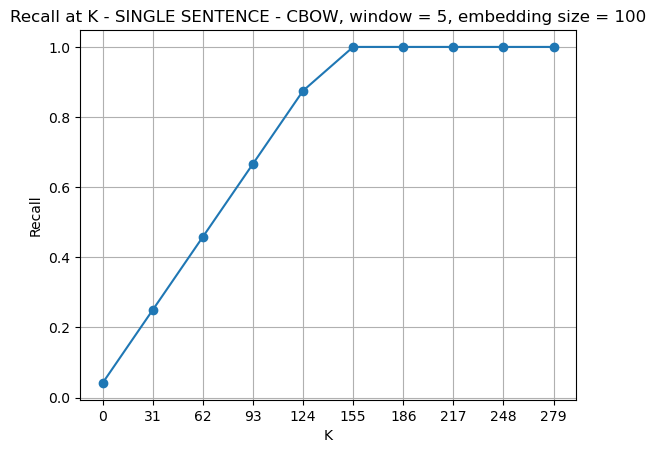

In [804]:
plt.plot(K_values, recall_list, marker='o')
plt.title('Recall at K - SINGLE SENTENCE - CBOW, window = 5, embedding size = 100')
plt.xlabel('K')
plt.ylabel('Recall')
plt.xticks(K_values)
plt.grid(True)
plt.show()

## the change in recall for different window sizes is not noticeable in this notebook
### changing to CBOW also makes only a tiny difference

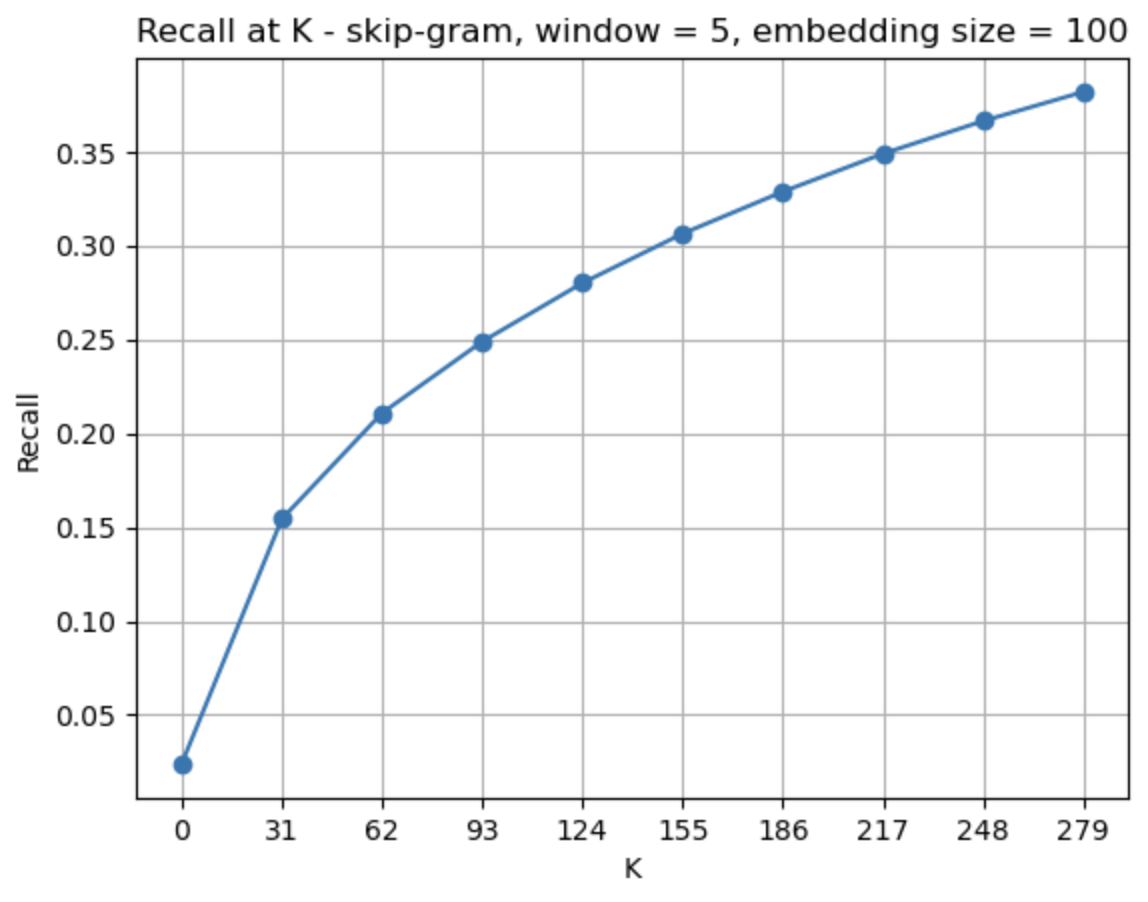
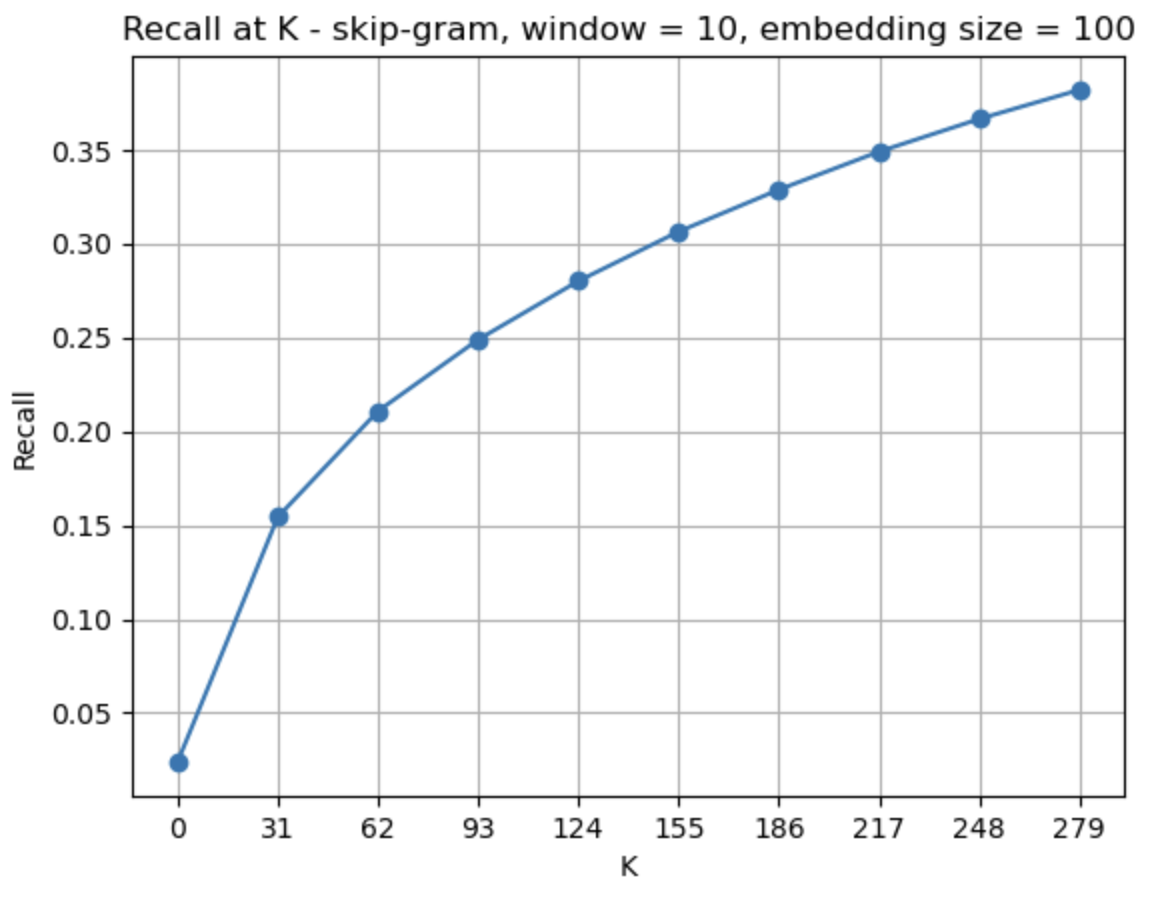
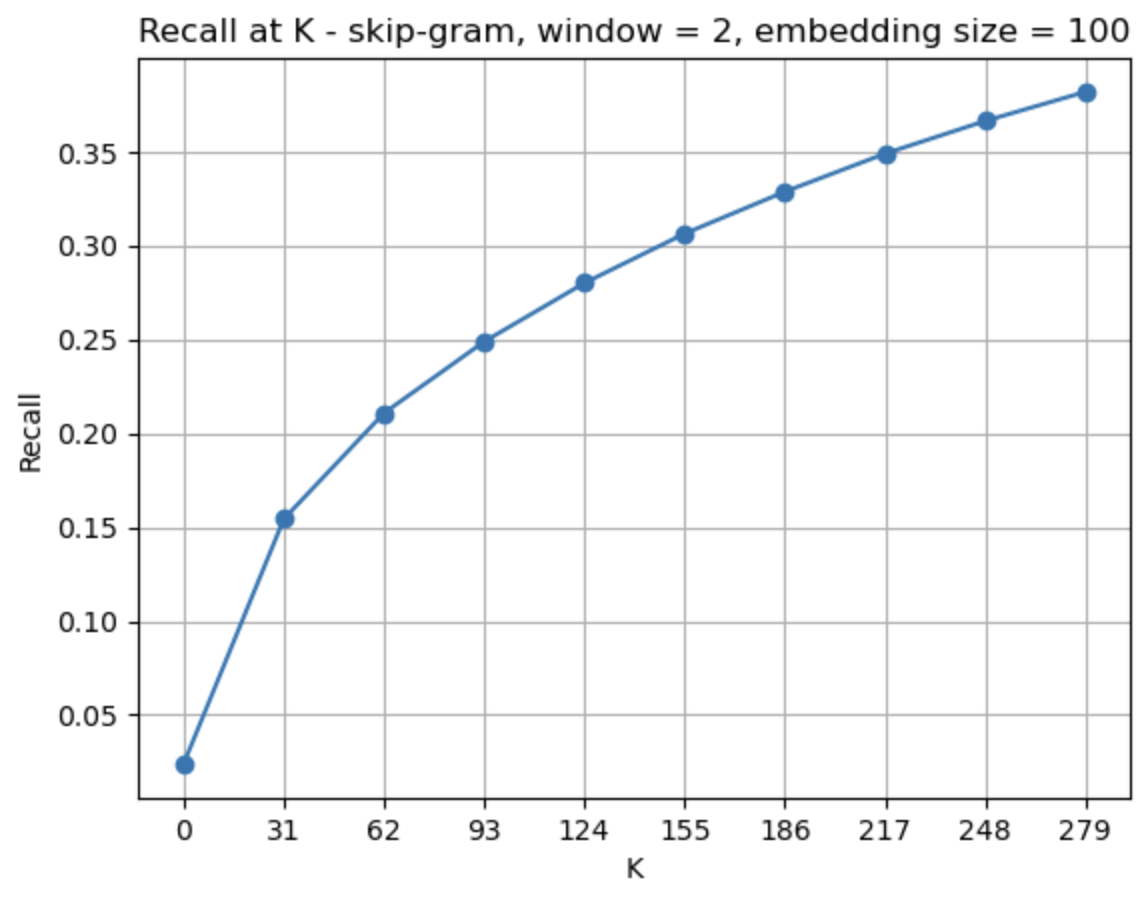
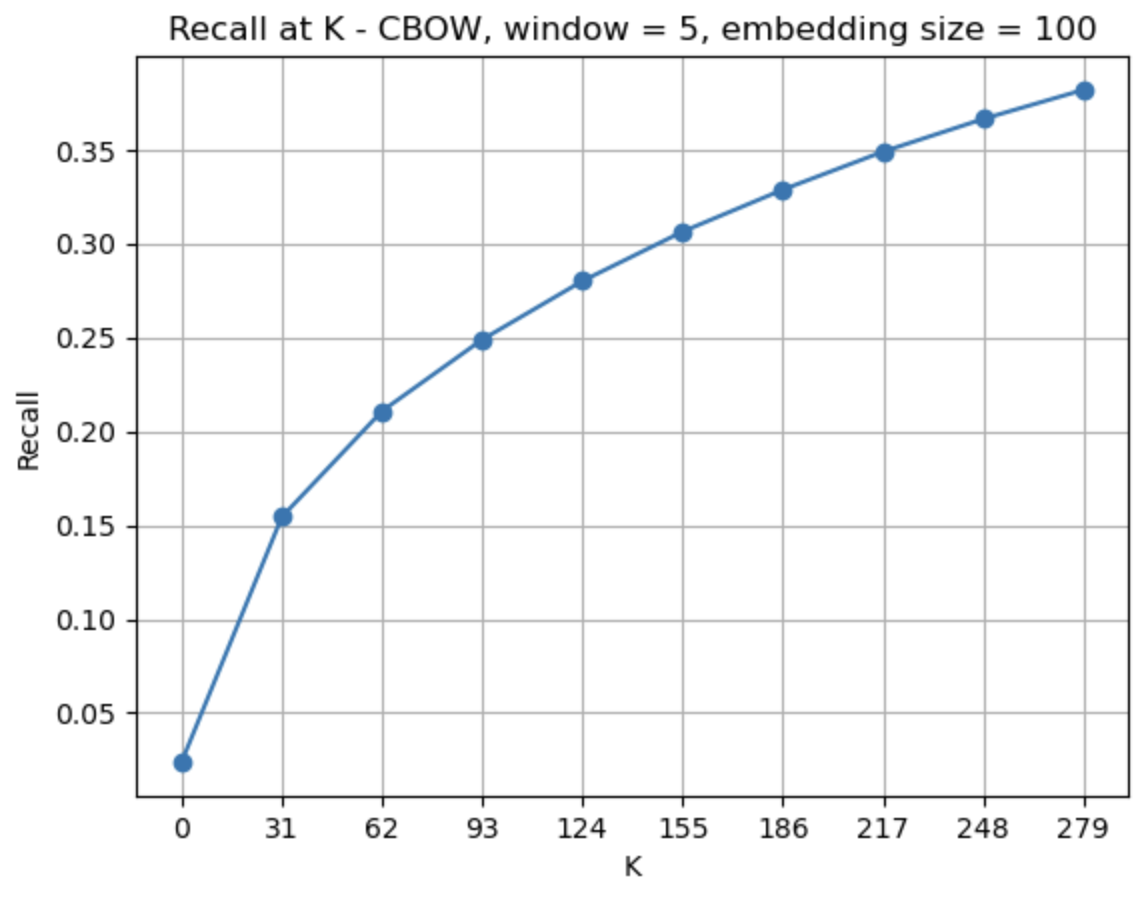

## now i can switch to checking the recall for a single sentence, such as "the police shot at the intruders":
### we can see that the top 155 are considered relevant here at a threshold for cosine sim of 0.3, which is really not even high at all

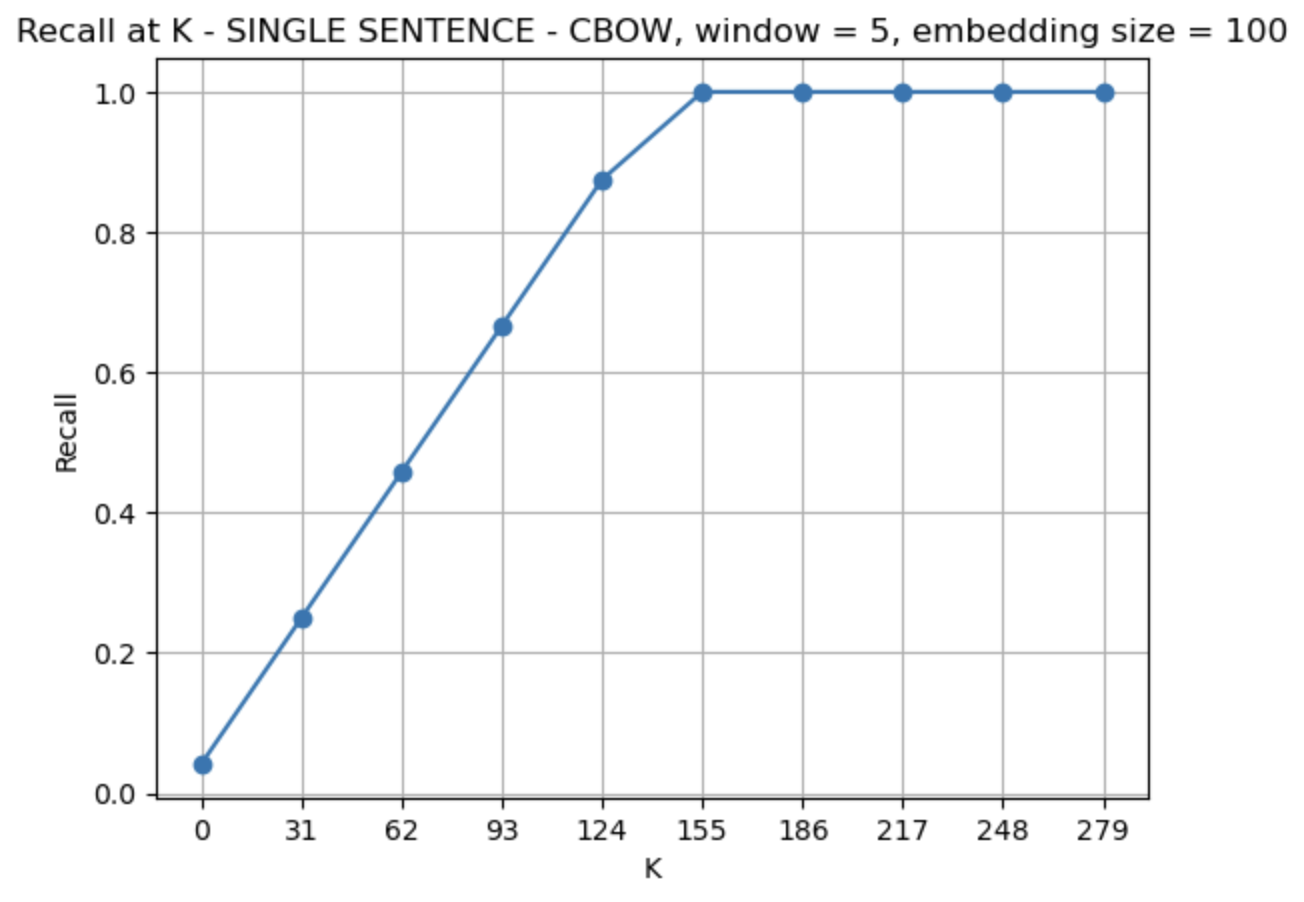

## we can also discuss everything I have tried
- changing the embedding size, from 50 to 250, didn't magically make the model much better
- similarly, changing from skip-gram to CBOW doesn't seem extremely impactful 
- changing the window size has a minimal effect on recall@k, as seen above
- changing the number of epochs to train the model on changes a lot, but maybe it overfits etc
- changing the recall to only consider a single sentence makes this so much easier to understand
- unfortunately, no matter what i tried, at some point after running and playing with the hundreds of different functions in this lab, my cosine similarity for any kind of sentence no matter the model just did not go above 0.5 frequently anymore, so a threshold of 0.3 for single queries was considered relevant, even though printing them out shows the results are not good nor relevant at all